# Bear Spring EPM (Equivalent Porous Media) Model

Model started 10/14/24. Modeled after Langevin, C. 2024, UMN Hydrocamp  
[Link to Reference Code](https://github.com/langevin-usgs/umn2024/tree/main)

## This is a copy of the actual EPM model that is designed solely to figure out how to get the watershed geoJSON file to fit onto a model grid with the appropriate Coordinate Reference System

In [2]:
# import python packages
import pathlib as pl #Pathlib used for switching between directories, accessing files
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for creating plots
from datetime import datetime #for dealing with datetime objects
import pandas as pd #for handling dataframes
import flopy #Used for interacting with MODFLOW, developing MODFLOW inputs and reading outputs
import rasterio #For working with raster data and shapefiles
import geopandas as gpd #For importing shapefiles
from shapely.geometry import LineString # For finding polygon boundaries
from shapely.geometry import Polygon
from shapely.validation import make_valid #For fixing polygon errors from imported data
from shapely.ops import unary_union
import csv #For creating CSV outputs from sensitivity analyses
import scipy.ndimage

## Load External Data

Import the Sinkhole and Spring Data  
Import Watershed data  
Import Bear Creek Location Data  
Import Precipitation Data

In [3]:
#Load the Watershed Extent data from USGS StreamStats
geoJSON = './data/HUC_12.geojson'
watershed = gpd.read_file(geoJSON)

projected_crs = 'EPSG:32615'
watershed = watershed.to_crs(projected_crs)

#Check for geometry types (need to extract a polygon dataset)
watershed_types = watershed.geometry.type.unique()
print(watershed_types)

#Generate a Polygon object from the watershed geoJSON
wsPolygon = watershed[watershed.geometry.type == 'Polygon']

#repair the geometry for any errors that make the polygon not valid
wsPolygon.loc[:,'geometry'] = wsPolygon['geometry'].apply(make_valid)
print(f'The polygon is Valid: {wsPolygon.is_valid}')
wsPolygon = wsPolygon.explode(index_parts=True)

#get the bounding box for the watershed polygon
bounds = wsPolygon.total_bounds
print(f'min x: {bounds[0]}, min y: {bounds[1]}, max x: {bounds[2]}, max y: {bounds[3]}')

#Get the area of the watershed polygon
wsArea = wsPolygon['geometry'].area.sum()
print(f'Watershed area: {wsArea/1e6:.2f} Km^2')

#Import the karst feature data (UTME, UTMN, elevation data)
f = pl.Path('./data/karst_features.csv')
karst_df = pd.read_csv(f)
karst_df = karst_df.set_index("ID") #Set the index for the karst dataframe to the feature name
karst_df['Elevation_m'] = karst_df['Elevation_ft'] * 0.3048 # create a new col. with the m elevation

#Isolate the spring and sinkhole coordinates for plotting on DEM
springs = karst_df[karst_df['Type'] == 'spring' ] #get springs
sinkholes = karst_df[karst_df['Type'] == 'sink' ] #get sinkholes

#Import the creek data shapefile
creeks = gpd.read_file('./data/creeks_geoJSON.geojson')
creeks = creeks.to_crs(wsPolygon.crs) #Set the coordinate reference system for the shapefile
creeks = gpd.clip(creeks, wsPolygon) #Mask out all the shapefile data that is not inside of the wsPolygon

#Import the precipitation data for the month of may (daily totals)
f = pl.Path('./data/BS_precip_5_1_24_5_30_24.csv')
precip_df = pd.read_csv(f)
precip_df = precip_df.drop(columns = ['NAME', 'SNOW', 'SNWD', 'STATION']) #remove unecessary columns
precip_df = precip_df.set_index("DATE") # Set the Date values as the indices for the array
precip_df['PRCP'] = precip_df['PRCP'] * 0.001 #convert from mm to meters
precip_df['time'] = range(len(precip_df))

#Import the discharge data for the month of may
f = pl.Path('./data/')

['Point' 'Polygon']
The polygon is Valid: 1    True
dtype: bool
min x: 552414.3972794723, min y: 4865615.877233875, max x: 561054.4101949929, max y: 4874795.869936911
Watershed area: 51.41 Km^2


In [4]:
geoJSON = './data/Bear_Springshed.geojson'
springshed = gpd.read_file(geoJSON)

projected_crs = 'EPSG:32615'
springshed = springshed.to_crs(projected_crs)

#Check for geometry types (need to extract a polygon dataset)
springshed_types = springshed.geometry.type.unique()
print(springshed_types)

#Generate a Polygon object from the watershed geoJSON
bsPolygon = springshed[springshed.geometry.type == 'Polygon']

#repair the geometry for any errors that make the polygon not valid
bsPolygon.loc[:,'geometry'] = bsPolygon['geometry'].apply(make_valid)
print(f'The polygon is Valid: {bsPolygon.is_valid}')
bsPolygon = bsPolygon.explode(index_parts=True)

['Polygon']
The polygon is Valid: 0    True
dtype: bool


In [5]:
#Create helper functions

#Get karst feature data from karst_df
def get_karst_data(ID):
    return karst_df.loc[ID].to_dict()

#Get DEM elevation data for a karst feature point
def get_cell_elev(ID):
    k_feat = get_karst_data(ID)
    i, j = sg.intersect(k_feat['UTME'], k_feat['UTMN'])
    elev = dem_grid[i,j]
    #print(f'Feature ID: {ID},row: {i}, col: {j}, DEM_elev: {elev} ')
    return elev, i, j

#Get elevations, cell i, j intersections for the structured grid with the creek
def get_creek_cells(creek, conductance = 100):
    river_cells = set() #Initialize a list of the cells where the creek meets the sg
    #iterate over the line segment of the creek shapefile
    for line in creek.geometry:
        for coord in list(line.coords): #Access each coordinate in the line for the shapefile
            x , y = coord
            i, j = sg.intersect(x,y)
            # Check if the cell is in the active domain
            if idomain[0, i, j] == 1:  # Assuming idomain is 3D (nlay, nrow, ncol)
                elev = dem_grid[i, j]
                river_cells.add((0, i, j, elev, conductance))
    return list(river_cells)

#Get elevations, i, j intersectiosn for the structured grid with the creek
def get_creek_cellsv2(creek, conductance = 100):
    river_cells = [] #Initialize a list of the cells where the creek meets the sg

    #initialize over all creek geometries
    gi = flopy.utils.GridIntersect(sg) #set up the grid intersection object
    
    creek_geom = creek.geometry.values[0] #Creek geometry, get values
    
    xp = gi.intersect(creek_geom)
    for intersect in xp:
        cellid = intersect[0]
        i, j = cellid
    for record in xp:
        cellid = record['cellids']
        i, j = cellid
            
        #Check if the cell is active
        if idomain[0, i, j] == 1:
            elev = dem_grid[i, j] #Get elev from DEM grid
            river_cells.append((0, i, j, elev, conductance))
    return river_cells

# Ensure "island" cells are deactivated using flood-fill algorithm
def remove_isolated_cells(idomain):
    for k in range(idomain.shape[0]):  # Iterate over layers
        # Label connected components of active cells
        labeled_array, num_features = scipy.ndimage.label(idomain[k] == 1)
        
        # Find sizes of each connected component
        component_sizes = np.bincount(labeled_array.ravel())
        
        # Keep only the largest connected component (or set threshold for size)
        largest_component = np.argmax(component_sizes[1:]) + 1  # Ignore 0 (inactive cells)
        
        # Deactivate isolated cells
        idomain[k][labeled_array != largest_component] = 0

In [6]:
type(wsMerged.geometry.values[0])

NameError: name 'wsMerged' is not defined

In [7]:
type(creeks.geometry.values[0])

shapely.geometry.linestring.LineString

In [8]:
get_creek_cellsv2(creeks)

NameError: name 'sg' is not defined

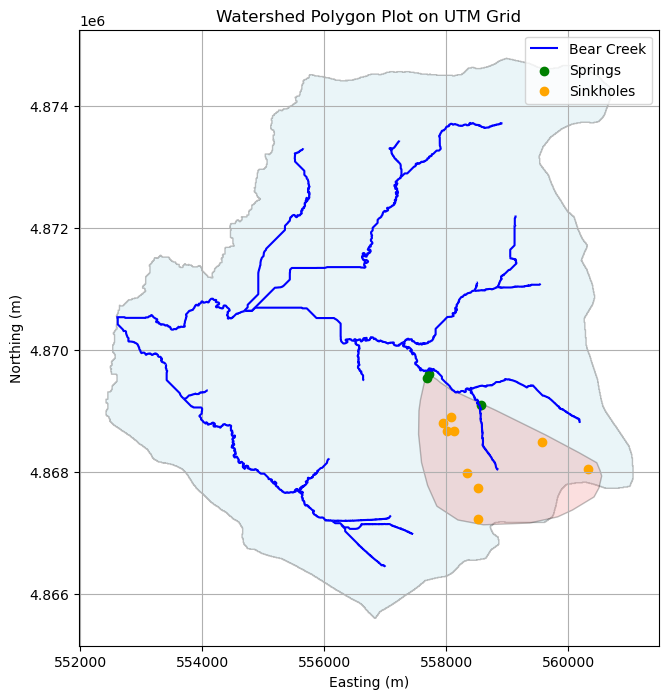

In [9]:
# Plot the polygon using the correct CRS to ensure that the bounds are in the right coordinate system and that the polygon looks correct
fig, ax = plt.subplots(figsize=(8, 8))
wsPolygon.plot(ax=ax, color='lightblue', edgecolor='black', alpha = 0.25)
bsPolygon.plot(ax=ax, color='lightcoral', edgecolor='black', alpha = 0.25)
creeks.plot(ax=ax, color='blue', label='Bear Creek')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Watershed Polygon Plot on UTM Grid')
plt.grid(True)
#Plot the springs and sinkholes on this grid
plt.scatter(springs['UTME'], springs['UTMN'], color = 'green', label='Springs')
plt.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes')
plt.legend()

The polygon is Valid: 0    True
dtype: bool


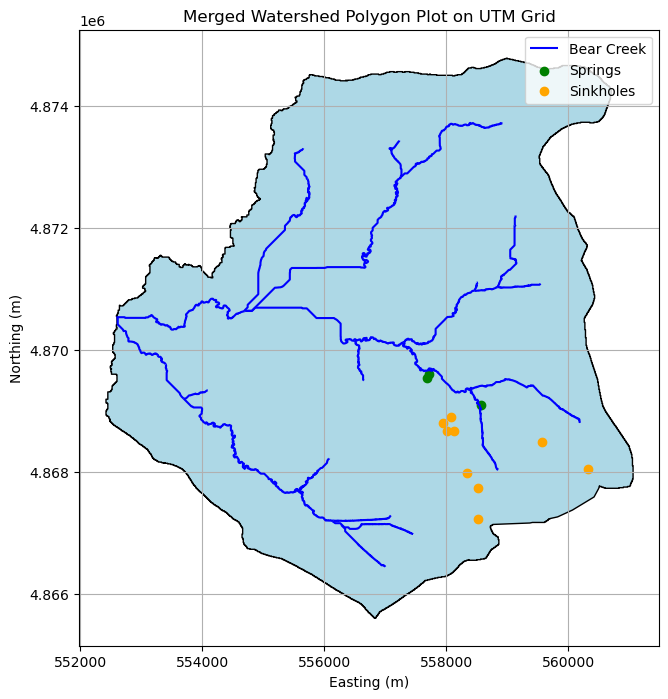

In [10]:
#Combine the polygons into a collective list
polygons = list(wsPolygon['geometry']) + list(bsPolygon['geometry'])

#Merge the polygon list into a singular polygon
merged = unary_union(polygons)

#Convert the merged polygon to a GeoDataFrame (gdf) object
wsMerged = gpd.GeoDataFrame([{'geometry': merged}], crs=projected_crs)

#repair the geometry for any errors that make the polygon not valid
wsMerged.loc[:,'geometry'] = wsMerged['geometry'].apply(make_valid)
print(f'The polygon is Valid: {wsMerged.is_valid}')
wsMerged = wsMerged.explode(index_parts=True)

#Plot the new domain shape from the merged polygons
fig, ax = plt.subplots(figsize=(8, 8))
wsMerged.plot(ax=ax, color = 'lightblue', edgecolor = 'black')
creeks.plot(ax=ax, color='blue', label='Bear Creek')
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.title('Merged Watershed Polygon Plot on UTM Grid')
plt.grid(True)
#Plot the springs and sinkholes on this grid
plt.scatter(springs['UTME'], springs['UTMN'], color = 'green', label='Springs')
plt.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes')
plt.legend()

#Get the new bounds of the merged polygon
bounds = wsMerged.total_bounds

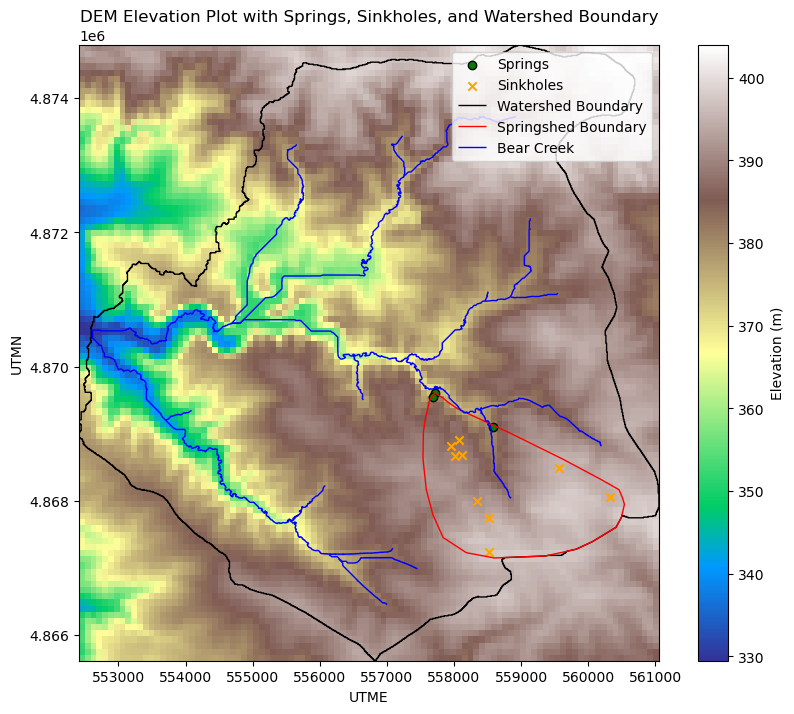

Current UTM Boundary: 552414.3972794723
Current UTM Boundary: 4865615.877233875
Current UTM Boundary: 561054.4101949929
Current UTM Boundary: 4874795.869936911


In [11]:
#Import the DEM data

ncol = 100 # number of grid columns in the model (Needs to be the same for the DEM grid conversion and for the model)
nrow = 100 # number of grid rows in the model (Needs to be the same for the DEM grid conversion and for the model)


with rasterio.open('./data/DEM_1m/dem_1m_m.bil') as src:
    #define the window of useful data(in UTM coords) from the larger DEM shapefile
    window = rasterio.windows.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], transform=src.transform)
    extent = rasterio.windows.bounds(window, src.transform)#get window boundaries to confirm they are correct
    
    #convert all of the data to a grid so it can be used with the MODFLOW model
    width = ncol#set the width of the grid
    height = nrow #set the height of the grid
    transform = rasterio.transform.from_bounds(*extent, width, height) #transform the data to the grid
    
    #Import the DEM and apply it to the grid
    dem_grid = src.read(
    1,
    out_shape = (height, width),
    window = window,
    resampling= rasterio.enums.Resampling.bilinear
    )
    
    #mask out the erroneous data (excessively large values due to data errors)
    maxval = 10000
    dem_grid = np.ma.masked_where(dem_grid > maxval, dem_grid)
    
# Plot DEM as a color plot to evaluate all of the values and establish the value range and units
fig, ax = plt.subplots(figsize=(10, 8))
dem_plot = ax.imshow(
    dem_grid,
    cmap='terrain',
    extent=[extent[0], extent[2], extent[1], extent[3]],
    origin='upper'
)
# Add a colorbar for the DEM
cbar = plt.colorbar(dem_plot, ax=ax, label='Elevation (m)')
# Plot springs and sinkholes on the DEM
ax.scatter(
    springs['UTME'], springs['UTMN'],
    color='green', label='Springs', marker='o', edgecolor='black'
)
ax.scatter(
    sinkholes['UTME'], sinkholes['UTMN'],
    color='orange', label='Sinkholes', marker='x'
)
# Overlay the merged watershed (wsMerged GeoDataFrame)
wsMerged.boundary.plot(ax=ax, color='k', linewidth=1, label='Watershed Boundary')
#Overlay the Springshed Area (Should be within the merged area)
bsPolygon.boundary.plot(ax=ax, color ='red', linewidth=1, label ='Springshed Boundary')
#Overlay the creeks
creeks.plot(ax=ax, color= 'blue', linewidth=1, label='Bear Creek')
# Add labels and title
ax.set_xlabel('UTME')
ax.set_ylabel('UTMN')
ax.set_title('DEM Elevation Plot with Springs, Sinkholes, and Watershed Boundary')
ax.legend()
plt.show()


#print the boundary values of the DEM
for i in range(len(extent)):
    print(f'Current UTM Boundary: {extent[i]}')

## Create the MODFLOW Model Grid

Place the grid onto real world coordinates for use with the DEM data and geological data

In [12]:
#Set all of the relevant input parameters for the grid construction
Lx = bounds[2] - bounds[0] #Use the bounding box of the model to be the length along the x axis
Ly = bounds[3] - bounds[1] #Use the bounding box of the model to be the length along the y axis
nlay = 3 #stewartville/Prosser, BPP, Cummingsville #Adding a 4th layer to act as the land surface
#nrow = 100 #set above in the DEM grid 
#ncol = 100 #set above in the DEM grid
delr = Lx / ncol * np.ones(ncol, dtype=float)
delc = Ly / nrow * np.ones(nrow, dtype=float)
top = dem_grid #elevation of the singular layer top
botm_layers = [372.161, 371.856, 352.044] #m above sea lvl (bottom Stewartville + Prosser, bottom BPP, bottom Cummingsville)
botm = np.ones((nlay, nrow, ncol), dtype=float) #set up the bottom arrays
#assign the elevations to the bottom arrays for the grid
for k in range(nlay):
    botm[k] = botm_layers[k]

In [13]:
# Add in a top "Sediment" layer everywhere, see if this works
sed_bot = top - 0.5 #m

botm = np.array(np.vstack([sed_bot[np.newaxis, :, :], botm]))

nlay = 4


In [14]:
# Generate the model grid in flopy
sg = flopy.discretization.StructuredGrid(
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xoff=bounds[0],
    yoff=bounds[1],
    crs= 'EPSG:32615'
)

In [15]:
#Get coordinates for sinkholes and springs in terms of i, j on the modelgrid

#Get all of the coordinates for the sinkholes
sinkhole_cells = [] #create an empty list for the sinkhole data
for i in range(len(karst_df[karst_df['Type'] == 'sink'])):
    df = karst_df[karst_df['Type'] == 'sink']
    sinkhole = df.iloc[i]
    elev, row, col = get_cell_elev(sinkhole.name)
    sinkhole_cells.append((sinkhole.name, elev, row, col))

#get all of the coordinates for the springs (NOT including Bear Spring)
spring_cells = [] #create an empty list for the sinkhole data
for i in range(len(karst_df[karst_df['Type'] == 'spring'])):
    df = karst_df[karst_df['Type'] == 'spring']
    spring = df.iloc[i]
    elev, row, col = get_cell_elev(spring.name)
    spring_cells.append((spring.name, elev, row, col))

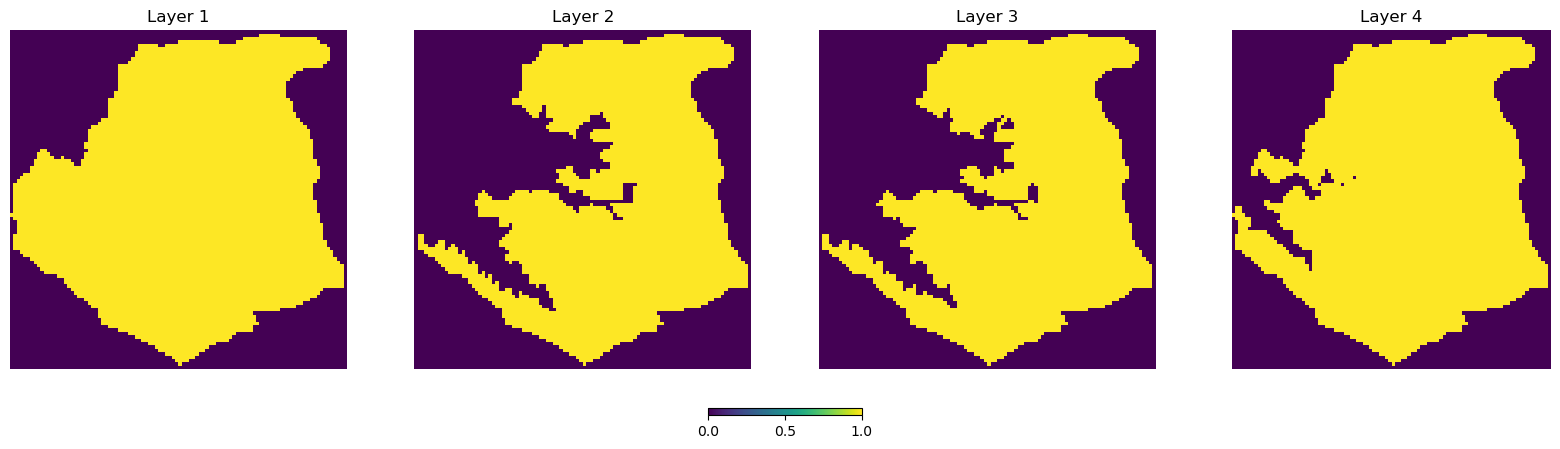

In [16]:
#create an idomain indicator array to activate and deactivate cells
idomain = np.zeros((nlay, nrow, ncol), dtype=int)

#create a flopy grid intersect object to use with the idomain array
gi = flopy.utils.GridIntersect(sg)

#extract the raw Polygon from the GeoDataFrame object wsPolygon (or the merged polygon)
domain = wsMerged.geometry.values[0]

#extract the raw polygon from the GDF object bsPolygon
bsdomain = bsPolygon.geometry.values[0]

#inside the domain polygon (watershed polygon)
ixp = gi.intersect(domain)
for i, j in ixp["cellids"]:
    idomain[:, i, j] = 1
    
#Set the second layer (BPP) idomain active cells to be only the bear springshed
#idomain[2, :, :] = 0 #reset everything to 0 for the BPP layer
ixbs = gi.intersect(bsdomain)
for i, j in ixbs["cellids"]:
    idomain[2, i, j] = 1

#Use the idomain array to deal with areas where the bot. elevation exceeeds surface
for k in range(nlay): #iterate through the layers
    for i in range(nrow): #iterate across the rows
        for j in range(ncol): #iterate across the columns
            if botm[k, i, j] >= top[i, j]:
                idomain[k, i, j] = 0 #turn off any cells with botm elev > top elev
    
#For layer 2 (layer 1 in python array terms) turn off any cells where botm[1] > = botm[0]
for i in range(nrow):
    for j in range(ncol):
        if botm[1, i, j] >= botm[0, i, j]:
            idomain[1, i, j] = 0

#touching the domain polygon (idomain = 2) (boundary cells)
ls = LineString([p for p in domain.exterior.coords])
ixl = gi.intersect(ls)
for i, j in ixl["cellids"]:
    # Set boundary cells to 2, but only if they are already active (i.e., thickness > 0)
    if np.all(idomain[:, i, j] == 1):  # only set to 2 if not already deactivated
        idomain[:, i, j] = 2

#Ensure no single-cell islands across all layers
for k in range(1, nlay):  # Start from the second layer
    for i in range(1, nrow - 1):
        for j in range(1, ncol - 1):
            if idomain[k, i, j] == 1:
                # Check horizontal and vertical neighbors for connectivity
                neighbors = [
                    idomain[k, i - 1, j], idomain[k, i + 1, j],
                    idomain[k, i, j - 1], idomain[k, i, j + 1],
                    idomain[k - 1, i, j]  # Include vertical connection
                ]
                if sum(neighbors) == 0:  # If no neighbors are active
                    idomain[k, i, j] = 0

#Use the method developed at the top of the code to remove isolated cells and groups of cells
remove_isolated_cells(idomain)

#Plot the idomain array for each layer of the model    
fig, axes = plt.subplots(1, nlay, figsize=(5 * nlay, 5))  # Create subplots in a single row

for i, ax in enumerate(axes):
    pmv = flopy.plot.PlotMapView(modelgrid=sg, layer=i)  # Specify the layer
    cb = pmv.plot_array(idomain[i], ax=ax)  # Plot the i-th layer
    ax.set_title(f'Layer {i+1}')  # Add title to each subplot
    ax.axis('off')  # Turn off axes for clarity

# Add a single colorbar for all plots
fig.colorbar(cb, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1, shrink=0.8)

plt.show()

## Assign Aquifer Properties

In [17]:
#Assign hydraulic conductivity (K) values for each of the layers
KhSed = 0.01
KhSP = 60 * 0.3048
KhBPP = 9581.51 #This value is the average dye trace velocity from 2015-2023 traces
KhCummingsville = 10 * 0.3048 
KvSed = 5000
KvSP = 0.6 * 0.3048
KvBPP = 20 * 0.3048
KvCummingsville = 0.0001 * 0.3048

#Order these conductivities into layers, convert to arrays
Kv = [KvSed, KvSP, KvBPP, KvCummingsville] #m/day
Kh = [KhSed, KhSP, KhBPP/100, KhCummingsville] #m/day #lower the KhBPP by 2 OOM, will incrase in the springshed
Kv = np.array(Kv) #1x4 array
Kh = np.array(Kh) #1x 4 array

#Convert into the grid array for use in model
K11 = Kh[:, np.newaxis, np.newaxis] * np.ones((nlay, nrow, ncol))
K33 = Kv[:, np.newaxis, np.newaxis] * np.ones((nlay, nrow, ncol))

#Change specific cell conductivities (Sinkholes)

#Create a list of cells which have sinkholes
sink_cells = np.ones((len(sinkholes.index), 2), dtype = int)

for q in range(len(sinkholes.index)):
    name = sinkholes.index[q]
    elev, i, j = get_cell_elev(name)
    sink_cells[q, 0] = int(i)
    sink_cells[q, 1] = int(j)

#Assign increased Kv values in the Sed and Sv + Pr layers where there are sinkholes
for q in range(len(sink_cells)):
    i = sink_cells[q][0]
    j = sink_cells[q][1]
    new_Kv0 = 10000 #K33[0, i, j] * 10
    new_Kv1 = 10000 #K33[1, i, j] * 10
    K33[0, i, j] = new_Kv0 #increase local Kv in the sed layer
    K33[1, i, j] = new_Kv1 #increase local Kv in SV + Pr layer
    
#Assign increased Kh value in the 3rd layer (BPP) in the springshed, everywhere else make it lower by 2 OOM
ixbs = gi.intersect(bsdomain)
for i, j in ixbs["cellids"]:
    K11[2, i, j] = KhBPP

## Build and Run the Simulation

### Steady-State version of the model

In [18]:
ws = './sim-01_EPM_wsgrid'
name = 'EPM_wsgrid'

#generate the simulation object
sim = flopy.mf6.MFSimulation(
    sim_name=name,
    sim_ws=ws,
    exe_name='mf6',
    version = 'mf6'
)

#Build the time inputs
tuni = 'DAYS'
nper = 1 #The number of stress periods
nstp = 1 #The number of timesteps
perlen = 1.0 #The length of each stress period
tsmult = 1.0 #length of successive timesteps

#Generate the tdis object (starting w/ tdis set up for steady state model)
tdis = flopy.mf6.ModflowTdis(
    sim,
    pname = "tdis",
    time_units = tuni,
    nper = nper,
    perioddata = [(perlen, nstp, tsmult)]
)

#Create the IMS package (iterative model solver)
ims = flopy.mf6.ModflowIms(
    sim,
    pname='ims',
    inner_dvclose = 0.0001,
    outer_dvclose = 0.0001,
    linear_acceleration="BICGSTAB",
    complexity = "SIMPLE"
)

#Create the groundwater flow model
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname = name,
    save_flows = True,
    newtonoptions = 'NEWTON UNDER_RELAXATION'
)

#create the discretization package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay = nlay,
    nrow = nrow,
    ncol = ncol,
    delr = delr,
    delc = delc,
    top = top,
    botm = botm,
    xorigin = extent[0],
    yorigin = extent[1],
    idomain = idomain
)

#Set up the drain which will represent Bear Spring and the river
BSelev , iBS, jBS = get_cell_elev('55A00406') #get the elevation, cell location for Bear Spring
kBS = 2 #layer of Bear Spring (layer 1, connected to the BPP)
BS_conductance = KhBPP #set the conductance of the spring = to the BPP conductivity
BS_drain = [(kBS, iBS, jBS, BSelev, BS_conductance)] #build the Bear Spring drain list
river_drain = get_creek_cells(creeks) #get the list of all the drain cell loations, elevs, conductances

drnspd = BS_drain + river_drain #combined list of the drain data to pass into MODFLOW DRN package ##I AM STILL HAVING ISSUES WITH THE river_drain!!

#Drain package
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    stress_period_data = drnspd,
    save_flows = True
)

#initial conditions (estimated water table elevation)
wtElev = top - 1 #setting the wt elevation below the surface everywhere to start
strt = wtElev * np.ones((nlay ,nrow , ncol))
strt[idomain == 0] = 0 #ensure the strt array is only assigned to active cells (idomain == 1))
ic = flopy.mf6.ModflowGwfic(gwf, strt = strt)

#node property flow package
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    k = K11,
    k33 = K33,
    icelltype = 0,
    save_specific_discharge = True
)

#No storage package as the model is in steady state, thus storage is constant
# For now, set the boundary cells (idomain=2) to constant head BC
#Set up the constant head boundary condition array (assign to cells where idomain == 2)
chdspd = []
for k in range(nlay):
    for i in range(nrow):
        for j in range(ncol):
            if idomain[k, i, j] == 2:  # boundary cells
                chdspd.append([(k, i, j), top[i, j]])
                
#Assign constant head package (CHD)
#chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data = chdspd)

#define evapotranspiration params
evtr = 0.001
exdp = 0.3 #m depth where EVT turns off

#build stress period array
spd = [] #initialize
for i in range(nrow):
    for j in range(ncol):
        if idomain[0, i, j] == 1:  # Use only active cells
            spd.append(((0, i, j), top[i, j], evtr, exdp))

stress_period_data = {0: spd}  # Apply to the first stress period

#Create the EVT pkg
evt = flopy.mf6.ModflowGwfevt(
    gwf,
    maxbound = nrow * ncol,
    stress_period_data = stress_period_data,
    pname = 'EVT'
)

#set the recharge condition to be a very small amount of recharge
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge = 0.0001)

#set the output control module for ease of access later
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=f"{name}.bud",
                            head_filerecord=f"{name}.hds",
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

### Transient Version of the model

In [ ]:
# ws = './sim-01_EPM_wsgrid'
# name = 'EPM_wsgrid'

# #generate the simulation object
# sim = flopy.mf6.MFSimulation(
#     sim_name=name,
#     sim_ws=ws,
#     exe_name='mf6',
#     version = 'mf6'
# )

# #Set the time discretization variables
# tuni = 'DAYS'
# nper = len(precip_df) #number of stress periods
# nstp = 24 #24 timesteps each day
# perlen = 1.0 #Total duration month (30days)
# tsmult = 1.0 #Uniform timestep length

# #Update the Timediscretization (TDIS)
# tdis = flopy.mf6.ModflowTdis(
#     sim,
#     pname = 'tdis',
#     time_units = tuni,
#     nper = nper,
#     perioddata = [(perlen, nstp, tsmult) for _ in range(nper)]
# )

# #Create the IMS package (iterative model solver)
# ims = flopy.mf6.ModflowIms(
#     sim,
#     pname='ims',
#     inner_dvclose=1e-3,  # Increase tolerance for inner convergence
#     outer_dvclose=1e-3,  # Increase tolerance for outer convergence
#     rcloserecord=1e-3,   # Increase residual closure criteria
#     linear_acceleration='BICGSTAB',  # Keep BiCGSTAB for transient simulations
#     inner_maximum=100,   # Allow more inner iterations
#     outer_maximum=50     # Allow more outer iterations
# )

# #Create the groundwater flow model
# gwf = flopy.mf6.ModflowGwf(
#     sim,
#     modelname = name,
#     save_flows = True,
#     newtonoptions = 'NEWTON UNDER_RELAXATION'
# )

# #Set up the recharge package (at this stage, only using the precipitation for recharge)
# rch_data = {i: rate for i, rate in enumerate(precip_df['PRCP'])}
# rch = flopy.mf6.ModflowGwfrcha(
#     gwf,
#     print_input = True,
#     recharge = rch_data, #set up the precipitation timeseries
#     pname = 'RCH',
#     save_flows = True
# )

# #create the discretization package
# dis = flopy.mf6.ModflowGwfdis(
#     gwf,
#     nlay = nlay,
#     nrow = nrow,
#     ncol = ncol,
#     delr = delr,
#     delc = delc,
#     top = top,
#     botm = botm,
#     xorigin = extent[0],
#     yorigin = extent[1],
#     idomain = idomain
# )

# #Set up the drain which will represent Bear Spring and the river
# BSelev , iBS, jBS = get_cell_elev('55A00406') #get the elevation, cell location for Bear Spring
# kBS = 1 #layer of Bear Spring (layer 1, connected to the BPP)
# BS_conductance = KhBPP #set the conductance of the spring = to the BPP conductivity
# BS_drain = [(kBS, iBS, jBS, BSelev, BS_conductance)] #build the Bear Spring drain list
# river_drain = get_creek_cells(creeks) #get the list of all the drain cell loations, elevs, conductances

# drnspd = BS_drain + river_drain #combined list of the drain data to pass into MODFLOW DRN package 

# #Drain package
# drn = flopy.mf6.ModflowGwfdrn(
#     gwf,
#     stress_period_data = drnspd,
#     save_flows = True
# )

# #initial conditions (estimated water table elevation)
# wtElev = top - 10 #setting the wt elevation below the surface everywhere to start
# strt = wtElev * np.ones((nlay ,nrow , ncol))
# strt[idomain == 0] = 0.0 #ensure the strt array is only assigned to active cells (idomain == 1))
# ic = flopy.mf6.ModflowGwfic(gwf, strt = strt)

# #Set up the parameters for the ET package
# #Define ET parameters
# evtr = 0.000001 # Max ET rate (m/day)
# extdp = 2.0 #Extinction depth (m below surface)
# evtf = top #Assign ET to the land surface elev

# #Create EVT stress period data
# nrow, ncol = top.shape
# evtr_array = np.full((nrow, ncol), evtr)
# extdp_array = np.full((nrow, ncol), extdp)

# # Build stress period data, excluding inactive cells (idomain = 0)
# evtspd = {
#     0: [
#         ((0, i, j), evtr, extdp, evtf[i, j])
#         for i in range(nrow) for j in range(ncol)
#         if idomain[0, i, j] == 1
#     ]
# }

# #Add EVT package
# evt = flopy.mf6.ModflowGwfevt(
#     gwf,
#     maxbound=nrow * ncol,
#     stress_period_data=evtspd,
#     print_input=True,
#     print_flows=True,
#     save_flows=True,
#     pname='EVT'
# )

# #node property flow package
# npf = flopy.mf6.ModflowGwfnpf(
#     gwf,
#     k = Kh,
#     k33 = Kv,
#     icelltype = 0,
#     save_specific_discharge = True
# )
# sy = 0.2

# sto = flopy.mf6.ModflowGwfsto(
#     gwf,
#     sy = sy
# )

# #set the output control module for ease of access later
# oc = flopy.mf6.ModflowGwfoc(gwf,
#                             budget_filerecord=f"{name}.bud",
#                             head_filerecord=f"{name}.hds",
#                             printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
#                             saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])



In [19]:
# write the MODFLOW input files
sim.write_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_wsgrid...
    writing model name file...
    writing package dis...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 441 based on size of stress_period_data
    writing package ic...
    writing package npf...
    writing package evt...
    writing package rcha_0...
    writing package oc...


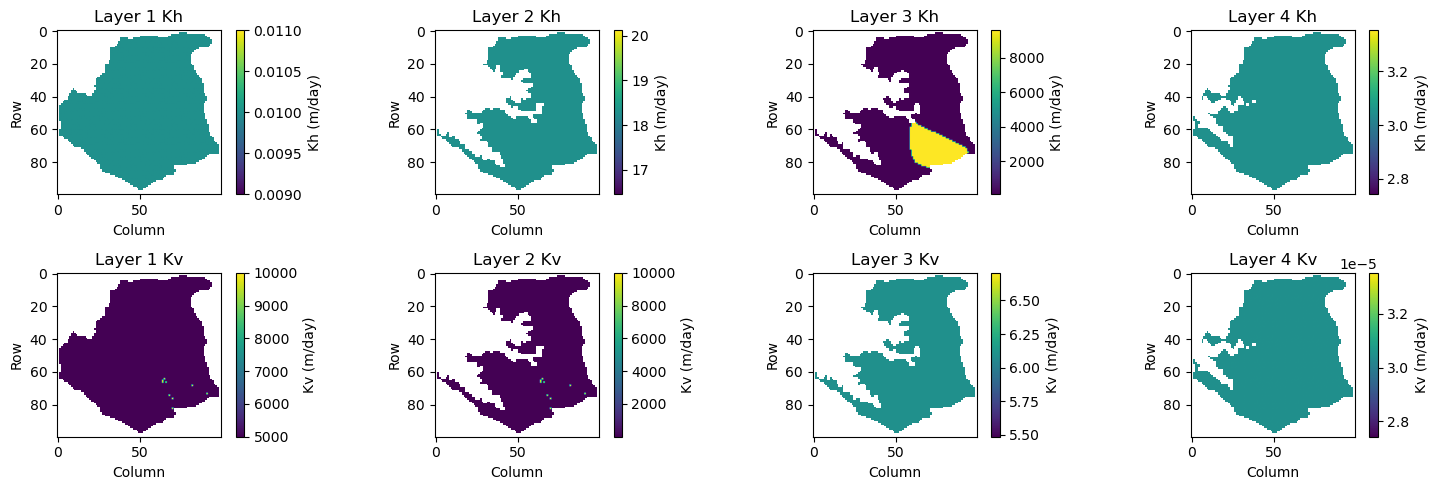

In [20]:
#Pre-visualize the conductivity fields in the model
Kh_view = npf.k.array
Kv_view = npf.k33.array

#Honor the idomain array
Kh_view = np.ma.masked_where(idomain == 0, Kh_view)
Kv_view = np.ma.masked_where(idomain == 0, Kv_view)

#plot
fig, axes = plt.subplots(2, nlay, figsize=(15, 5))

for i in range(nlay):
    ax = axes[0, i]
    im = ax.imshow(Kh_view[i], cmap='viridis', origin='upper')
    ax.set_title(f"Layer {i + 1} Kh")
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    fig.colorbar(im, ax=ax, label="Kh (m/day)")
    
    #2nd row, Kv
    ax = axes[1,i]
    im = ax.imshow(Kv_view[i], cmap='viridis', origin='upper')
    ax.set_title(f"Layer {i + 1} Kv")
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")
    fig.colorbar(im, ax=ax, label="Kv (m/day)")

plt.tight_layout()
plt.show()


In [21]:
#run the MODFLOW simulation
sim.run_simulation(silent= False) #Set silent to False if you want to print out the messages during the simulation run

FloPy is using the following executable to run the model: ../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 10/18/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Oct 18 2024 02:59:03 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that nei

(False, [])

## Post Process the model outputs

In [22]:
# load the output from the simulation
head = gwf.output.head().get_alldata()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

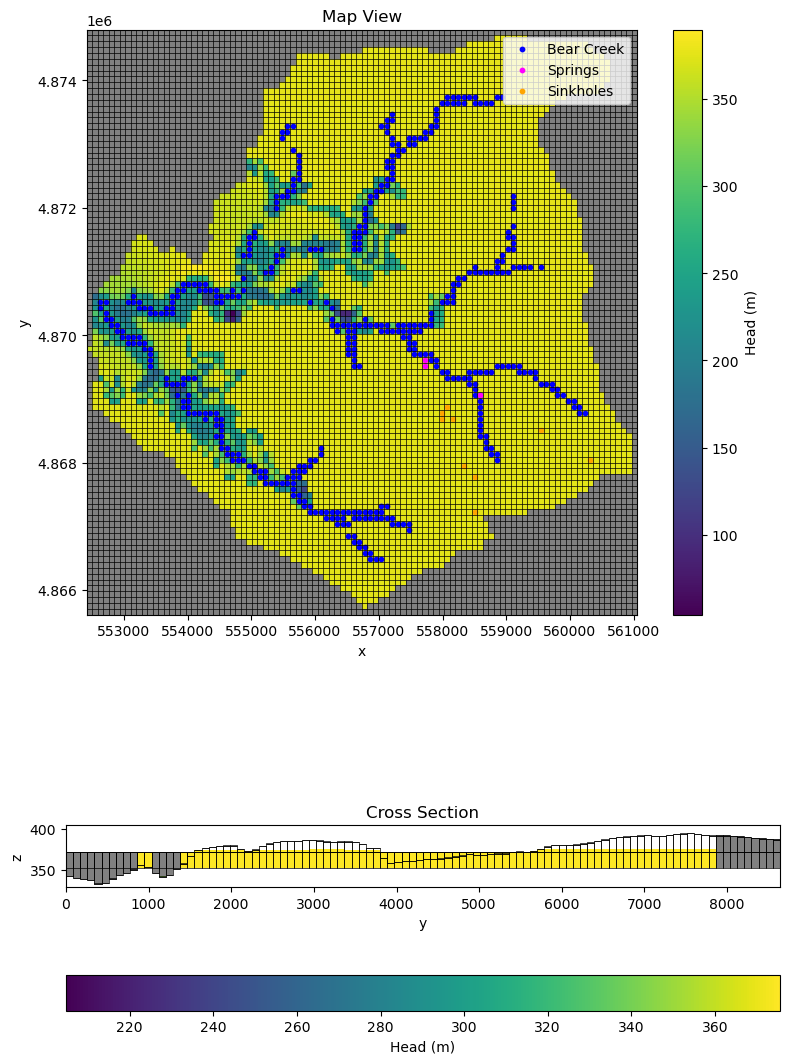

In [23]:
# create a plot of the model results
fig, axes = plt.subplots(2, 1, figsize=(8, 11))
ax = axes[0] 
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
max_head = np.max(head[head != 1e30]) #get the max head for the colorbar
min_head = np.min(head)
#pmv.plot_bc(ftype="CHD") 
cb = pmv.plot_array(head[0][0]) #plot the head at the start of the model
pmv.plot_inactive(color_noflow="gray")
pmv.plot_grid(color="black", linewidth=0.5)
#pmv.contour_array(head[0,0,:,:])
#pmv.plot_vector(qx, qy, normalize=True, color="black", istep=1, jstep=1)
#ax.scatter(springs['UTME'], springs['UTMN'], color = 'magenta', label='Springs') #This plots raw UTME and UTMN, not in cells
#ax.scatter(sinkholes['UTME'], sinkholes['UTMN'], color='orange', label = 'Sinkholes') #This plots raw UTME and UTMN, not in cells
plt.colorbar(cb, label = "Head (m)")

# Get cell locations for Bear Creek
river_cells = [(cell[1], cell[2]) for cell in river_drain]  # Extract row and column indices from river_drain
river_x = [sg.xcellcenters[row, col] for row, col in river_cells] # Get x coordinates of river cells in the grid
river_y = [sg.ycellcenters[row, col] for row, col in river_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
spring_x = [sg.xcellcenters[row, col] for name, elev, row, col in spring_cells] # Get x coordinates of river cells in the grid
spring_y = [sg.ycellcenters[row, col] for name, elev, row, col in spring_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for the Sinkholes in the model
#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
sinkhole_x = [sg.xcellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get x coordinates of river cells in the grid
sinkhole_y = [sg.ycellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get y coordinates of river cells in the grid

#Plot the creek, spring, and sinkhole cells on the map
ax.scatter(river_x, river_y, color='blue', s=10, label = 'Bear Creek') # PLot the river_drain cells
ax.scatter(spring_x, spring_y, color='magenta', s=10, label = 'Springs') # PLot the spring_drain cells
ax.scatter(sinkhole_x, sinkhole_y, color = 'orange', s=10, label = 'Sinkholes')
ax.legend()

ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("y")
ax.set_ylabel("z")
pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": int(ncol/2)})
pxs.plot_inactive(color_noflow="gray")
#pxs.plot_bc(ftype="CHD")
pxs.plot_array(head, head=head)
cb = pxs.plot_array(head, head=head)
pxs.plot_grid(color="black", linewidth=0.5)
plt.colorbar(cb, orientation='horizontal', label = 'Head (m)')
plt.tight_layout()

/tmp/ipykernel_3898310/2720463539.py:27: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


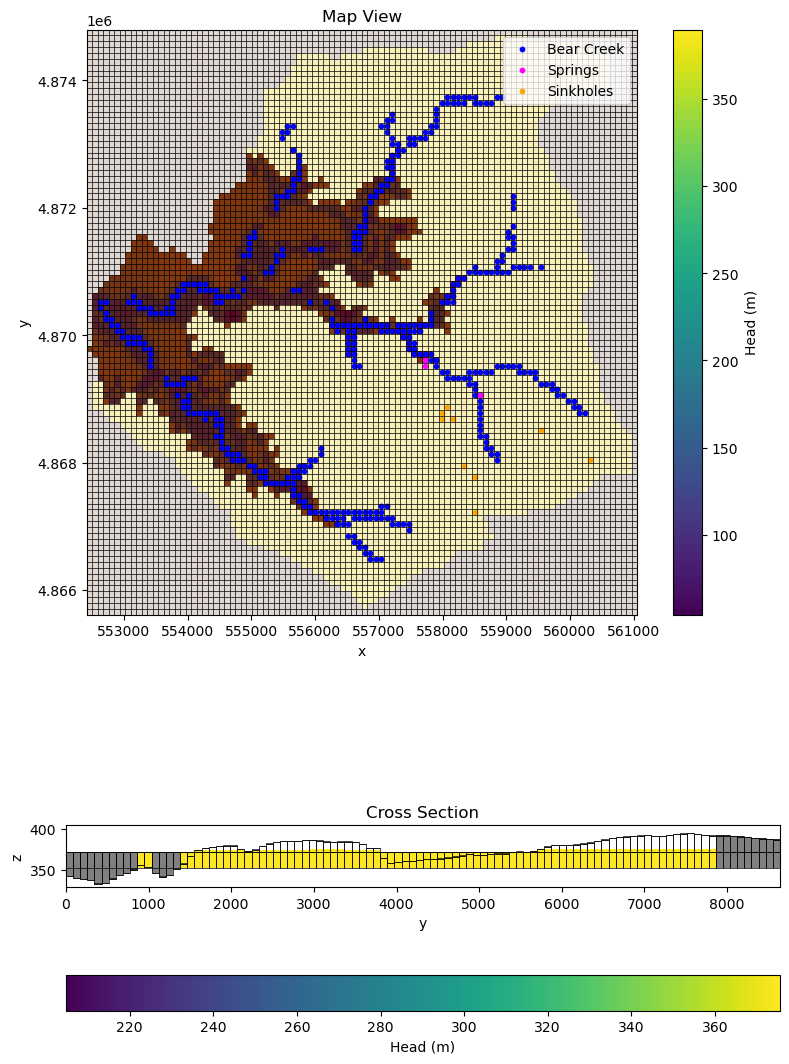

In [24]:
#Plot the locations where the hydraulic head exceeds the land surface elevation
excess_head_mask = np.zeros_like(head[0][0])
valid_mask = (head[0][0] < 1e30)  # Exclude cells with head >= 1e30
excess_head_mask[(head[0][1] > top) & valid_mask] = 1  # Mark cells with valid excess head

# Plot the model results
fig, axes = plt.subplots(2, 1, figsize=(8, 11))
ax = axes[0] 
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")

# Map view plot
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
cb = pmv.plot_array(head[0][0])  # Plot the head at the start of the model
pmv.plot_inactive(color_noflow="gray")
pmv.plot_grid(color="black", linewidth=0.5)

# Overlay the excess head mask
pmv.plot_array(excess_head_mask, cmap="Reds", alpha=0.5, label="Excess Head")

# Plot features
ax.scatter(river_x, river_y, color='blue', s=10, label='Bear Creek')
ax.scatter(spring_x, spring_y, color='magenta', s=10, label='Springs')
ax.scatter(sinkhole_x, sinkhole_y, color='orange', s=10, label='Sinkholes')
ax.legend()

plt.colorbar(cb, label="Head (m)")

# Cross-section plot
ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("y")
ax.set_ylabel("z")

pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": int(ncol / 2)})
pxs.plot_inactive(color_noflow="gray")
pxs.plot_array(head, head=head)
cb = pxs.plot_array(head, head=head)
pxs.plot_grid(color="black", linewidth=0.5)
plt.colorbar(cb, orientation="horizontal", label="Head (m)")

# Tight layout for plots
plt.tight_layout()

In [ ]:
#Setup for undoing the linear indexing used to assign values to the drian cells

# linear_index = 1188

# k = linear_index // (nrow * ncol)  # Calculate the layer index
# i = (linear_index % (nrow * ncol)) // ncol  # Calculate the row index
# j = linear_index % ncol  # Calculate the column index

# print(k, i, j)

In [ ]:
#Produce sensitivity analysis files for the changes to the specific yield (sy)
#will need to put everything into a loop temporarily

#get the discharge from the BS drain and River drains
cbb_file = f"{ws}/{name}.bud"
cbb = flopy.utils.CellBudgetFile(cbb_file)

#Get all of the drain data from the cbb
drn_discharge = cbb.get_data(text='DRN') #retrieve all of the DRN flows

drn_array = np.array(drn_discharge) #convert the nested array to a format where it can actually be read

#calculate the total discharge through bear spring over the entire model, units of L**3
BS_m3 = 0
for i in range(len(drn_array[:,0])): #Bear Spring is the 0th index in the drn_array
    BS_m3 = BS_m3 + drn_array[:,0][i][2] * -1
BS_m3 = BS_m3 / 24 #convert to the correct units to account for the hourly tsteps (raw values given in m3/day, but the # of tsteps is hourly)
print(f"Total Bear Spring Discharge: {BS_m3:.0f} m³")

#Bear Creek Drain Cells total discharge
BC_m3 = 0 #Initialize the total discharge sum

# Loop over all timesteps (720 timesteps)
for i in range(np.shape(drn_array)[0]):  # Iterate over timesteps (rows of drn_array)
    # Loop over all drains, skipping the 0th drain
    for n in range(1, np.shape(drn_array)[1]):  # Start at n=1 to skip the 0th drain
        # Access the discharge value (3rd element of the tuple)
        BC_m3 += abs(drn_array[i, n][2])  # Add the absolute discharge value
        
BC_m3 = BC_m3 / 24 #convert to the correct units to account for the hourly tsteps (raw values given in m3/day, but the # of tsteps is hourly)   

# Print the total discharge in cubic meters (m³)
print(f"Total Bear Creek Discharge: {BC_m3:.0f} m³")
total_drain = BC_m3 + BS_m3
print(f"Total System Discharge: {total_drain:.0f} m³")

In [ ]:
# Create a gif of the aquifer heads over time
#test making a gif
from PIL import Image
from IPython.display import display, Image as IPImage

frame_folder = pl.Path('frames')
frames = []
for i in range(round(len(head)/24)): #Simulate the number of days (Only getting the plots from the end of each day)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.set_title(f"Map View: Day ={i + 1}")
    ax.set_aspect(1)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    max_head = np.max(head[head != 1e30]) #get the max head for the colorbar
    min_head = np.min(head)
    #Plot map view
    pmv = flopy.plot.PlotMapView(gwf, ax=ax) 
    cb = pmv.plot_array(head[i * 24,0,:,:], cmap = 'viridis', vmin = min_head, vmax = max_head)
    pmv.plot_inactive(color_noflow="gray")
    pmv.plot_grid(color="black", linewidth=0.5)
    #pmv.contour_array(head[i,0,:,:])
    #pmv.plot_vector(qx, qy, normalize=True, color="black", istep=1, jstep=1)
    cbar = fig.colorbar(cb, ax=ax, shrink=0.8, label="Head Values")  # Adjust `shrink` if needed for better fit
    #Plot the creek, spring, and sinkhole cells on the map
    ax.scatter(river_x, river_y, color='blue', s=15, label = 'Bear Creek') # PLot the river_drain cells
    ax.scatter(spring_x, spring_y, color='magenta', s=15, label = 'Springs') # PLot the spring_drain cells
    ax.scatter(sinkhole_x, sinkhole_y, color = 'orange', s=15, label = 'Sinkholes')
    ax.legend()

    frame_path = frame_folder / f"frame_{i}.png"
    plt.savefig(frame_path)
    plt.close()
    
    frames.append(Image.open(frame_path))


# Step 2: Create GIF
frames[0].save("head_evolution.gif", save_all=True, append_images=frames[1:], duration=1000, loop=0)

# Step 3: Display the GIF
with open("head_evolution.gif", "rb") as f:
    display(IPImage(data=f.read()))

## Sensitivity Analyses

In [ ]:
#Run a sensitivity analysis for the Sy parameter
# Define the output CSV file
output_file = "sensitivity_analysis_sy.csv"

# Write the header for the output CSV file
with open(output_file, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["sy", "total_drain_m3", "BC_m3", "BS_m3", "max_head_m"])

# Loop through specific yield values
for sy in np.arange(0.1, 1, 0.1):  # From 0.1 to 2.0 inclusive, step 0.2
    print(f"Running simulation for sy = {sy:.1f}")

    # Update specific yield in the storage package
    sto.sy.set_data(sy)
    
    # Write and run the simulation
    sim.write_simulation(silent=True)
    sim.run_simulation(silent=True)

    # Load simulation results
    head = gwf.output.head().get_alldata()
    bud = gwf.output.budget()
    spdis = bud.get_data(text="DATA-SPDIS")[0]
    max_head = np.max(head[head != 1e30])

    # Get the drain discharge data
    cbb_file = f"{ws}/{name}.bud"
    cbb = flopy.utils.CellBudgetFile(cbb_file)
    drn_discharge = cbb.get_data(text="DRN")
    drn_array = np.array(drn_discharge)

    # Calculate Bear Spring discharge (BS_m3)
    BS_m3 = 0
    for i in range(len(drn_array[:, 0])):  # Bear Spring is the 0th index in the drn_array
        BS_m3 += drn_array[:, 0][i][2] * -1
    BS_m3 = BS_m3 / 24  # Convert to hourly timestep units

    # Calculate Bear Creek discharge (BC_m3)
    BC_m3 = 0
    for i in range(np.shape(drn_array)[0]):  # Iterate over timesteps
        for n in range(1, np.shape(drn_array)[1]):  # Skip the 0th drain
            BC_m3 += abs(drn_array[i, n][2])
    BC_m3 = BC_m3 / 24  # Convert to hourly timestep units

    # Calculate total discharge
    total_drain = BC_m3 + BS_m3

    # Write the results for this `sy` to the CSV file
    with open(output_file, "a", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([sy, total_drain, BC_m3, BS_m3, max_head])

print(f"Sensitivity analysis complete. Results saved to {output_file}")

#Plot the results from the sensitivity analysis
sens_sy = pd.read_csv('sensitivity_analysis_sy.csv')
fig, axs = plt.subplots(2,1, figsize = (9,12))
ax = axs[0]
ax.scatter(sens_sy['sy'], sens_sy['total_drain_m3'], label = 'Total Drainage')
ax.scatter(sens_sy['sy'], sens_sy['BC_m3'], label = 'BC Drainage')
ax.scatter(sens_sy['sy'], sens_sy['BS_m3'], label = 'BS Drainage')
ax.set_xlabel('sy', fontsize =15)
ax.set_ylabel('m^3', fontsize =15)
ax.legend(loc='upper right')
ax = axs[1]
ax.scatter(sens_sy['sy'], sens_sy['max_head_m'], label = 'Max Head')
ax.set_xlabel('sy', fontsize =15)
ax.set_ylabel('m', fontsize=15)
ax.legend()
